In [1]:
import copy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch,torchvision
from torch import nn,save,load       #neural network module
from torch.optim import Adam      #optimizer used
from torch.utils.data import DataLoader     #load a dataset
from torchvision import datasets         
from torchvision.transforms import ToTensor       #to convert to tensor
from sklearn import metrics



In [2]:
T=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.MNIST('mnist_data',train=True,download=True,transform=T)  #transforming to tensor
val_data=torchvision.datasets.MNIST('mnist_data',train=False,download=True,transform=T)
print(len(val_data))
test_set,val_set=torch.utils.data.random_split(val_data,[5000,5000])

train_dl=torch.utils.data.DataLoader(train_data,64)     #batch size =64
val_dl=torch.utils.data.DataLoader(val_set,64)     
test_dl=torch.utils.data.DataLoader(test_set,64)     

10000


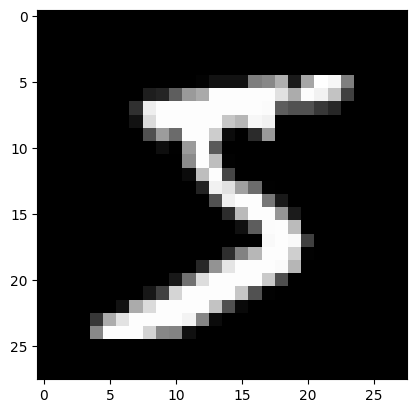

In [3]:
plt.imshow(train_data[0][0][0],cmap="gray")

In [4]:
class MNIST(nn.Module):
    
    def __init__(self):
        super(MNIST,self).__init__()
        self.model=nn.Sequential(
        nn.Conv2d(1,6,5,padding=2),     #input,output,filter dimensions the padding and stride
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Conv2d(6,16,5,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Flatten(),
        nn.Linear(400,120),           #16*5*5
        nn.Linear(120,84),
        nn.Linear(84,10)   #total no.of digits=10
        )
    
    
    def forward(self,out):
        x=self.model(out)
        return x

In [5]:

#accuracy of the model

def validate(model,data):
    total=0
    correct=0
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        total=total+x.size(0)
        correct=correct+torch.sum(pred==labels)
    return correct/total *100    
            
  

In [6]:
def train(epochs):
    
    accuracies=[]
    max=0
    cnn=MNIST().to('cpu')
    loss=nn.CrossEntropyLoss()
    opt=Adam(cnn.parameters(),lr=0.001)
    
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_dl):
            images=images.to('cpu')
            labels=labels.to('cpu')
            
            opt.zero_grad()        #initialising to zero
            pred=cnn(images)
            l=loss(pred,labels)
            l.backward()        #backpropagation
            opt.step()             #gradient descent
        accuracy=float(validate(cnn,val_dl))  
        accuracies.append(accuracy)
        if(accuracy>max):
            best_model=copy.deepcopy(cnn)
            max=accuracy
            print("Till now best accuracy: ",accuracy)
        plt.plot(accuracies)    
        print("Epoch:",epoch+1, "Accuracy: ",accuracy)
        
    return best_model   

Till now best accuracy:  95.8800048828125
Epoch: 1 Accuracy:  95.8800048828125
Till now best accuracy:  97.0999984741211
Epoch: 2 Accuracy:  97.0999984741211
Till now best accuracy:  98.0999984741211
Epoch: 3 Accuracy:  98.0999984741211
Till now best accuracy:  98.55999755859375
Epoch: 4 Accuracy:  98.55999755859375
Till now best accuracy:  98.86000061035156
Epoch: 5 Accuracy:  98.86000061035156


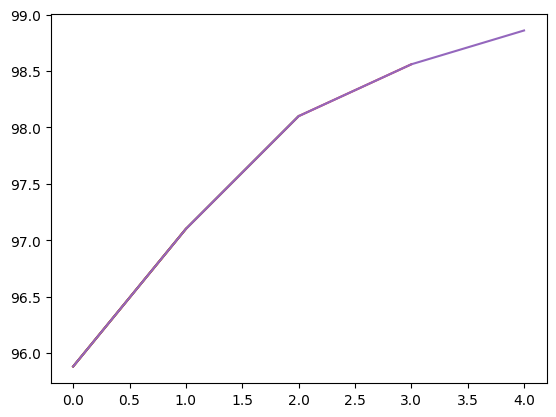

In [7]:
M=train(5)


In [8]:
#predicting the testing set

def predict(model,data):
    y_pred=[]
    y_true=[]
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred),np.array(y_true)    

In [9]:

y_pred,y_true=predict(M,test_dl)

In [10]:
#confusion matrix

x=metrics.confusion_matrix(y_true,y_pred,labels=np.arange(0,10))
x

array([[502,   0,   3,   0,   0,   0,   1,   1,   0,   0],
       [  0, 566,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   1, 527,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0, 516,   0,   4,   0,   0,   2,   1],
       [  1,   0,   0,   0, 482,   0,   0,   0,   1,   3],
       [  0,   0,   0,   1,   0, 426,   1,   0,   1,   2],
       [  1,   1,   0,   0,   0,   7, 450,   0,   1,   0],
       [  0,   3,   8,   1,   0,   0,   0, 488,   1,   0],
       [  4,   0,   4,   0,   1,   1,   0,   1, 470,   1],
       [  0,   2,   0,   1,   2,   1,   0,   1,   0, 506]], dtype=int64)

In [11]:
#saving parameters
model=MNIST()
torch.save(M.state_dict(),'model1.pt')

print(M.state_dict())

OrderedDict([('model.0.weight', tensor([[[[-0.0759, -0.1223, -0.4015, -0.3659, -0.2130],
          [ 0.1485,  0.0660, -0.3276, -0.3487, -0.4175],
          [-0.0545,  0.2191,  0.2145, -0.0045,  0.1868],
          [ 0.1801,  0.2441,  0.0030,  0.1816,  0.1717],
          [ 0.1296, -0.0864,  0.2481,  0.0704,  0.2938]]],


        [[[-0.1474,  0.1241, -0.0610,  0.1901,  0.0265],
          [-0.0712,  0.1769,  0.1790,  0.0735,  0.1171],
          [-0.0988,  0.0278,  0.1562,  0.0934,  0.1788],
          [-0.1732, -0.0239,  0.2124, -0.0712, -0.1746],
          [ 0.0540,  0.0461, -0.1786,  0.0306, -0.0825]]],


        [[[ 0.1614,  0.1640, -0.1038, -0.2408, -0.1205],
          [ 0.2586,  0.0774,  0.1844, -0.2633, -0.2305],
          [ 0.2280,  0.3353,  0.0308, -0.2588, -0.2993],
          [-0.0720,  0.3015,  0.1497, -0.1625, -0.0331],
          [ 0.0523,  0.1558,  0.0484,  0.2393, -0.0158]]],


        [[[-0.0943,  0.2498,  0.2513,  0.0766,  0.1329],
          [ 0.1685,  0.2640,  0.3278,  0.227